In this notebook I write queries to check the quality of the video game database and clean it with DML (Data Manipulation Language: INSERT, UPDATE, DELETE).

---

First, I look at the `game` table to check for duplicate `game_name`

In [ ]:
SELECT
    g.game_id,
    dup.genre_id,
    dup.game_name,
    gpb.game_publisher_id,
    gpb.publisher_id,
    gpf.platform_id,
    gpf.release_year
FROM
(
    SELECT
        genre_id,
        game_name,
        COUNT(*) as record
    FROM game
    GROUP BY genre_id,
        game_name
    HAVING COUNT(*) > 1
) dup 
JOIN game g ON dup.genre_id = g.genre_id
    AND dup.game_name = g.game_name
JOIN game_publisher gpb ON g.game_id = gpb.game_id
JOIN game_platform gpf ON gpb.game_publisher_id = gpf.game_publisher_id

**Here is the result:**

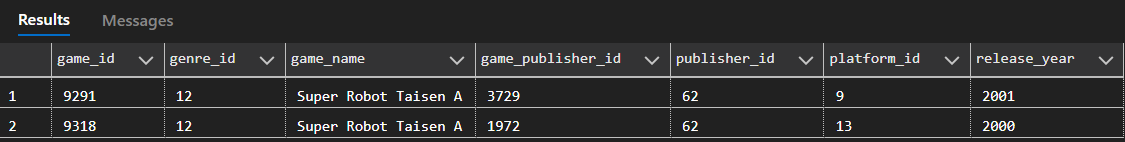  

There is one duplicate with the same `game_name` but different `game_id`, which leads to different `game_publisher_id`. But both titles have the same publisher, only made for two distinct platforms.

Before I can apply DML to correct the data, I need to disable the `CONSTRAINT` for these tables (in this case `FOREIGN KEY` constraint), or else the system will raise errors. I use **Azure Data Studio** (light-weight database tool from Microsoft) so I can disable and re-enable constraints easily using its GUI, but you can write statements like this:

For disabling constraints:

```
ALTER TABLE table_name
NOCHECK CONSTRAINT constraint_name;

```

For re-enabling constraints:

```
ALTER TABLE table_name
WITH CHEKC CHECK CONSTRAINT constraint_name;

```

To preserve the one-to-many relationship between `game` table and other tables, I do the following:

- Delete the row with `game_id 9318` from `game` table
- Continue to delete the row with `game_publisher_id 1972` in the `game_publisher` table since it referenced `game_id 9318`.
- Finally, change `game_publisher_id` in the `game_platform` table from `1972` to `3729`. At this moment, `game_id` and `game_publisher_id` have been unique across tables.

In [ ]:
DELETE from game
WHERE game_id = 9318

DELETE from game_publisher
WHERE game_publisher_id = 1972

UPDATE game_platform
SET game_publisher_id = 3729
WHERE game_publisher_id = 1972

Another table that has duplicates is `region_sale` table

In [ ]:
SELECT 
    region_id, 
    game_platform_id,
    COUNT(*) as record
FROM region_sales 
GROUP BY region_id, game_platform_id
HAVING COUNT(*) > 1

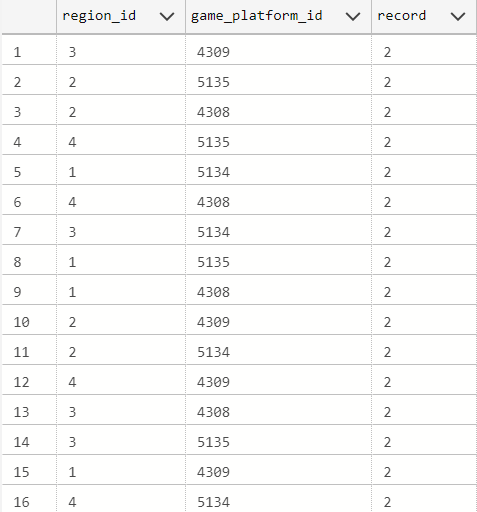

There are 16 duplicate values. But adding `num_sales` column to the group reveals that only 2 values have the same sales figure, which means other 14 values have different sales

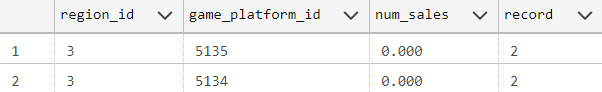

Because I don't know which sales number to keep, I will take a blind approach keep the higher sales. It might be wrong, but since my purpose is to demonstrate SQL queries rather than precise analysis, I can ignore this flaw.

In [ ]:
WITH dup_cte AS (
    select
        region_id,
        game_platform_id,
        num_sales,
        ROW_NUMBER() OVER (PARTITION BY region_id, game_platform_id ORDER BY num_sales DESC) AS row_number
    FROM region_sales
)
DELETE from dup_cte
WHERE row_number >= 2

Above I use `ROW_NUMBER()` window function to mark the duplicates. Duplicate values will have 2, 3,... in this `row_number` column. The `ORDER BY num_sales DESC` ensures that rows with highest sales will be marked as 1. Then I wrap the query as a CTE (Common Table Expression) and delete all rows other than the first occurence.

I can then add a group primary key to `region_id` and `game_platform_id` to enforce uniqueness for future data inserting and updating. The data from this point is ready for analysis.